<a href="https://colab.research.google.com/github/futaoo/semantic-energy/blob/main/ontoEnergy_extension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/SEST2021-journal/')

Mounted at /content/drive


##pip packages request

In [ ]:
pip install rdflib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 482 kB 9.9 MB/s 
     |████████████████████████████████| 41 kB 527 kB/s 


In [ ]:
import csv
import copy

from rdflib import URIRef, BNode, Literal
from rdflib.namespace import CSVW, DC, DCAT, DCTERMS, DOAP, FOAF, ODRL2, ORG, OWL, \
                           PROF, PROV, RDF, RDFS, SDO, SH, SKOS, SOSA, SSN, TIME, \
                           VOID, XMLNS, XSD
from rdflib import Namespace
from rdflib import Graph

from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import itertools

## ontology mapping

In [ ]:
df_pol = pd.read_csv('./datasets/airpollutants.csv')
df_pol.drop(['UptimeMinutes','RSSI_dbm'], inplace=True, axis=1)
df_pol.head()

,created_at,PM1.0_CF1_ug/m3,PM2.5_CF1_ug/m3,PM10.0_CF1_ug/m3,Temperature_F,Humidity_%,PM2.5_ATM_ug/m3
0,2019-06-01,9.34,13.09,14.32,66.66,57.95,13.05
1,2019-06-02,1.43,2.18,2.64,67.33,51.37,2.18
2,2019-06-03,2.11,3.14,3.79,62.42,51.49,3.13
3,2019-06-04,5.87,7.80,8.54,59.94,69.54,7.79
4,2019-06-05,1.71,2.38,2.68,57.88,67.70,2.38


###mapping function

In [ ]:
def format_uri(*strs):
    uri = strs[0]
    i=1
    while(i>0 and i<len(strs)-1):
        uri += (strs[i]+"&")
        i = i+1
    uri += strs[-1]
    return URIRef(uri)

def map_to_rdf(baseurl, var, val, time, graph):
    if var != "":
        val_uri = format_uri(baseurl, "observation?sensorid=26695", "var="+var.rsplit('_',1)[0], "time="+str(time))
        graph.add((val_uri, RDF.type, SOSA.Observation))
        graph.add((val_uri, SOSA.hasFeatureOfInterest, format_uri(baseurl, "air?sensorid=26695")))
        graph.add((format_uri(baseurl, "air?sensorid=26695"), SOSA.isSampleOf, format_uri(baseurl,"Air")))
        graph.add((format_uri(baseurl, "air?sensorid=26695"), RDF.type, SOSA.Sample))
        graph.add((val_uri, SOSA.observedProperty, format_uri(baseurl, var.rsplit('_',1)[0])))
        graph.add((format_uri(baseurl, var.rsplit('_',1)[0]), RDF.type, SOSA.ObservableProperty))
        graph.add((val_uri, SOSA.madeBySensor, format_uri(baseurl, "sensor?id=26695")))
        graph.add((val_uri, SOSA.hasSimpleResult, Literal(str(val)+'_'+var.split('_')[-1])))
        graph.add((val_uri, SOSA.resultTime, Literal(time,datatype=XSD.date)))




In [ ]:

baseurl = "http://jresearch.ucd.ie/climate-kg/purpleair/"

g = Graph()
g.bind("cap", "http://jresearch.ucd.ie/climate-kg/purpleair/")
g.bind("rdf", RDF)
g.bind("sosa", SOSA)
g.bind("xsd", XSD)
g.bind("rdfs", RDFS)
g.bind("geo", "http://www.w3.org/2003/01/geo/wgs84_pos#")
g.add((format_uri(baseurl, "sensor?id=26695"),RDF.type,format_uri(baseurl, "AirSensor")))
g.add((format_uri(baseurl, "AirSensor"), RDFS.subClassOf, SOSA.Sensor))
g.add((format_uri(baseurl, "sensor?id=26695"), format_uri(baseurl, "hasOwner"), format_uri(baseurl, "PurpleAir")))
g.add((format_uri(baseurl, "sensor?id=26695"), format_uri("http://www.w3.org/2003/01/geo/wgs84_pos#","long"), Literal("-6.273795")))
g.add((format_uri(baseurl, "sensor?id=26695"), format_uri("http://www.w3.org/2003/01/geo/wgs84_pos#","lat"), Literal("53.360861")))
g.add((format_uri(baseurl, "sensor?id=26695"), RDF.type, format_uri("http://www.w3.org/2003/01/geo/wgs84_pos#","SpatialThing")))


headers = list(df_pol.columns)
for index, row in df_pol.iterrows():
    for header in headers[1:]:
        map_to_rdf(baseurl, header, row[header], row[headers[0]], g)
triples = g.serialize(format="turtle")

with open('./data.ttl','w') as f:
    f.write(triples)


In [ ]:
qudt = Namespace("http://qudt.org/1.1/schema/qudt#")
# cresource = Namespace("http://jresearch.ucd.ie/climate-kg/resource/")
seas = Namespace("https://w3id.org/seas/")
unit = Namespace("http://qudt.org/vocab/unit/")
prov = Namespace("http://www.w3.org/ns/prov#")
car = Namespace("http://jresearch.ucd.ie/climate-kg/resource/")

In [ ]:
import pandas as pd
in_csv = './datasets/industrial1-pv-1min.csv'
number_lines =  sum(1 for row in (open(in_csv)))

In [ ]:
df = pd.read_csv(in_csv)
df = df[df['DE_KN_industrial1_pv_1'].notna()]
df = df[['utc_timestamp', 'DE_KN_industrial1_pv_1']]
rowsize=50000
for i in range(0, len(df), rowsize):
    df.iloc[i:i+rowsize].to_csv(f"./datasets/pv-split/Enronset_{i//rowsize}.csv",index=False)
# df.to_csv('./datasets/pv-split/fullset.csv', index=False)

In [ ]:
import csv
# csvpath = './hd2016.csv'
csvpath = './datasets/pv-split/Enronset_0.csv'
with open(csvpath) as f:
    csvreader =  csv.reader(f)
    record_head = list(next(csvreader))
    record_rows = list(csvreader)

In [ ]:
print(record_head)

['utc_timestamp', 'DE_KN_industrial1_pv_1']


In [ ]:
def format_uri(*strs):
    uri = strs[0]
    i=1
    while(i>0 and i<len(strs)-1):
        uri += (strs[i]+"_")
        i = i+1
    uri += strs[-1]
    return URIRef(uri)

def ts_mapping_to_rdf(baseuri, header, record, time, graph):
    if record != "":
        header_uri = format_uri(baseuri,header)
        evaluation_uri = format_uri(baseuri,header,time)
        graph.add((evaluation_uri, RDF.type, seas.ElectricPowerEvaluation))
        graph.add((header_uri, seas.evaluation, evaluation_uri))
        graph.add((evaluation_uri,prov.generatedAtTime,Literal(time,datatype=XSD.dateTime)))
        evaluatiion_value_uri = format_uri(baseuri,header,time,"value")
        graph.add((evaluatiion_value_uri, RDF.type, qudt.QuantityValue))
        graph.add((evaluation_uri,seas.evaluatedValue, evaluatiion_value_uri))
        graph.add((evaluatiion_value_uri, qudt.numericalValue, Literal(record,datatype=XSD.float)))
        graph.add((evaluatiion_value_uri, qudt.unit,unit["KiloW-HR"]))

In [ ]:
g = Graph()
g.bind("qudt", qudt)
g.bind("unit",unit)
g.bind("rdfs", RDFS)
g.bind("rdf", RDF)
g.bind("seas",seas)
g.bind("car",car)
g.bind("prov",prov)


In [ ]:
baseuri = "http://jresearch.ucd.ie/climate-kg/resource/cossmic/"
headers = copy.deepcopy(record_head)
# headers.remove('\ufeffutc_timestamp')
headers.remove('utc_timestamp')
# headers.remove('cet_cest_timestamp')
# headers.remove('interpolated')
print(headers)
for row in record_rows:
    for header in headers:
        ts_mapping_to_rdf(baseuri,header,row[record_head.index(header)],row[record_head.index(record_head[0])],g)
# triples = g.serialize(format="turtle").decode("utf-8")
triples = g.serialize(format="turtle")

with open('./Enronset_0.ttl','w') as f:
    f.write(triples)
    

['DE_KN_industrial1_pv_1']


In [ ]:
record_rows = [i for i in record_rows if i[3]!='']

In [ ]:
record_rows[0]

['2016-12-01T00:01:00Z',
 '2016-12-01T01:01:00+0100',
 'DE_KN_residential6_dishwasher | DE_KN_residential6_freezer | DE_KN_residential6_washing_machine',
 '5267.372742']

##extension for journal

In [ ]:
import pandas as pd
import matplotlib.pylab as plt

In [ ]:
df_cossmic = pd.read_csv('./datasets/hd2016.csv')
# df_cossmic.head()
df_cossmic['utc_timestamp'] = df_cossmic['utc_timestamp'].str.slice(0,10)
df_cossmic['utc_timestamp'] = pd.to_datetime(df_cossmic['utc_timestamp'],format='%Y-%m-%d')
df_cossmic.iloc[:,1:] = df_cossmic.iloc[:,1:].diff(periods=-1)*-1
df_cossmic

,utc_timestamp,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_pv,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,DE_KN_industrial3_area_room_2,DE_KN_industrial3_area_room_3,DE_KN_industrial3_area_room_4,...,DE_KN_residential5_dishwasher,DE_KN_residential5_grid_import,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine
0,2016-01-01,411.000,2.880,1.93,4.379,14.320,3.943,32.539,0.420,-0.0,...,2.147,13.635,0.921,0.506,1.042,0.002,0.581,13.615,4.790,0.202
1,2016-01-02,318.750,4.920,3.54,5.291,15.570,3.927,32.420,0.407,-0.0,...,0.003,11.355,0.881,0.684,1.075,0.411,0.605,15.237,4.790,0.258
2,2016-01-03,437.125,4.150,2.99,21.209,15.550,3.950,32.371,0.413,-0.0,...,1.974,15.005,0.957,2.247,1.190,0.002,0.569,16.221,4.790,0.001
3,2016-01-04,642.625,4.840,3.90,17.631,20.812,3.870,33.100,0.420,-0.0,...,0.002,9.310,0.860,0.578,1.146,0.001,0.545,14.290,4.790,0.309
4,2016-01-05,675.381,6.290,5.26,24.869,21.368,13.280,37.609,8.538,-0.0,...,1.640,11.500,0.857,-0.000,1.164,0.001,0.549,17.490,4.790,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2016-12-28,633.047,6.931,6.04,31.191,8.185,2.415,2.363,0.310,-0.0,...,0.003,9.430,0.930,1.848,1.338,0.082,0.112,11.160,17.429,0.055
363,2016-12-29,625.703,6.479,5.42,33.469,8.170,2.420,2.361,0.310,-0.0,...,1.787,10.120,0.863,0.652,1.638,0.222,0.115,13.070,19.071,-0.000
364,2016-12-30,633.844,1.521,0.58,5.633,9.235,2.439,2.354,0.300,-0.0,...,1.015,11.747,1.166,1.390,1.483,0.285,0.101,15.290,1.849,0.392
365,2016-12-31,355.531,1.380,0.48,5.258,6.735,2.526,2.351,0.300,-0.0,...,1.819,10.738,0.907,-0.000,1.427,0.285,0.202,13.250,1.731,0.969


In [ ]:
df_climate = pd.read_csv('./datasets/kz_climate_2016.csv')
df_climate['DATE'] = pd.to_datetime(df_climate['DATE'], format='%Y/%m/%d')
df_climate

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNWD,TMAX,TMIN
0,GME00102404,"KONSTANZ, GM",47.6781,9.1908,443,2016-01-01,0.0,0.0,4.7,2.3
1,GME00102404,"KONSTANZ, GM",47.6781,9.1908,443,2016-01-02,12.4,0.0,5.2,3.9
2,GME00102404,"KONSTANZ, GM",47.6781,9.1908,443,2016-01-03,7.0,0.0,7.8,2.8
3,GME00102404,"KONSTANZ, GM",47.6781,9.1908,443,2016-01-04,1.5,0.0,6.2,1.5
4,GME00102404,"KONSTANZ, GM",47.6781,9.1908,443,2016-01-05,0.8,0.0,7.8,2.8
...,...,...,...,...,...,...,...,...,...,...
361,GME00102404,"KONSTANZ, GM",47.6781,9.1908,443,2016-12-27,0.0,0.0,7.0,-0.9
362,GME00102404,"KONSTANZ, GM",47.6781,9.1908,443,2016-12-28,0.0,0.0,5.1,-2.5
363,GME00102404,"KONSTANZ, GM",47.6781,9.1908,443,2016-12-29,0.0,0.0,3.3,-4.3
364,GME00102404,"KONSTANZ, GM",47.6781,9.1908,443,2016-12-30,0.0,0.0,0.7,-2.1


In [ ]:
df_merge = pd.merge(df_cossmic,df_climate.iloc[:,5:],left_on='utc_timestamp',right_on='DATE').reset_index(drop=True)
df_merge.drop(['utc_timestamp','DATE'], inplace=True, axis=1)
df_merge_corrM = df_merge.corr()
df_merge_corrM

,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_pv,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,DE_KN_industrial3_area_room_2,DE_KN_industrial3_area_room_3,DE_KN_industrial3_area_room_4,DE_KN_industrial3_compressor,...,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,PRCP,SNWD,TMAX,TMIN
DE_KN_industrial1_grid_import,1.000000,0.288777,0.202960,0.237275,0.198341,0.218848,0.209459,0.177992,0.166777,0.166794,...,-0.442225,0.027484,-0.368279,-0.520361,0.226900,0.036190,-0.013936,-0.080239,0.397874,0.451535
DE_KN_industrial1_pv_1,0.288777,1.000000,0.909694,0.871381,-0.063461,0.066728,0.017192,0.024129,0.063056,0.123980,...,-0.442390,0.110071,-0.358521,-0.540022,0.878316,-0.121551,-0.140355,-0.144196,0.779747,0.644729
DE_KN_industrial1_pv_2,0.202960,0.909694,1.000000,0.887837,-0.106513,0.068053,0.011299,0.038209,0.060989,0.133754,...,-0.347311,0.148899,-0.391027,-0.520533,0.912054,-0.107978,-0.124258,-0.146461,0.802174,0.648670
DE_KN_industrial2_pv,0.237275,0.871381,0.887837,1.000000,-0.102671,0.068298,0.057786,0.069668,0.046183,0.114769,...,-0.343449,0.148541,-0.322693,-0.516774,0.953107,-0.110478,-0.176897,-0.226450,0.802513,0.621067
DE_KN_industrial3_area_offices,0.198341,-0.063461,-0.106513,-0.102671,1.000000,0.612827,0.732723,0.634855,0.524614,0.634120,...,0.027394,-0.014387,0.217445,0.174138,-0.126434,0.183750,0.022822,0.103912,-0.111734,-0.093417
DE_KN_industrial3_area_room_1,0.218848,0.066728,0.068053,0.068298,0.612827,1.000000,0.656559,0.541982,0.484858,0.610323,...,-0.091458,0.005513,0.056203,-0.008260,0.050014,0.187516,-0.025308,0.053842,0.048550,0.043603
DE_KN_industrial3_area_room_2,0.209459,0.017192,0.011299,0.057786,0.732723,0.656559,1.000000,0.600379,0.501204,0.652599,...,-0.066194,0.044230,0.120159,0.003237,0.023199,0.164147,-0.011533,0.100627,0.033472,0.037616
DE_KN_industrial3_area_room_3,0.177992,0.024129,0.038209,0.069668,0.634855,0.541982,0.600379,1.000000,0.595784,0.599843,...,0.048012,0.077270,0.056752,0.049885,0.043681,0.143132,0.013294,0.000913,0.005381,-0.013926
DE_KN_industrial3_area_room_4,0.166777,0.063056,0.060989,0.046183,0.524614,0.484858,0.501204,0.595784,1.000000,0.700381,...,-0.076834,0.094292,-0.027652,-0.028544,0.026255,0.117934,0.010456,0.021525,0.046351,0.056856
DE_KN_industrial3_compressor,0.166794,0.123980,0.133754,0.114769,0.634120,0.610323,0.652599,0.599843,0.700381,1.000000,...,-0.079252,0.073809,0.001689,-0.012357,0.101801,0.122697,0.015300,-0.039447,0.103628,0.106795


In [ ]:
df_merge[['ktmax']] = 10*df_merge[['TMAX']] + 5

In [ ]:
df_merge

,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_pv,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,DE_KN_industrial3_area_room_2,DE_KN_industrial3_area_room_3,DE_KN_industrial3_area_room_4,DE_KN_industrial3_compressor,...,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,PRCP,SNWD,TMAX,TMIN,ktmax
0,411.000,2.880,1.930,4.379,14.320,3.943,32.539,0.420,-0.0,45.492,...,0.002,0.581,13.615,4.790,0.202,0.0,0.0,4.7,2.3,52.0
1,318.750,4.920,3.540,5.291,15.570,3.927,32.420,0.407,-0.0,44.664,...,0.411,0.605,15.237,4.790,0.258,12.4,0.0,5.2,3.9,57.0
2,437.125,4.150,2.990,21.209,15.550,3.950,32.371,0.413,-0.0,45.195,...,0.002,0.569,16.221,4.790,0.001,7.0,0.0,7.8,2.8,83.0
3,642.625,4.840,3.900,17.631,20.812,3.870,33.100,0.420,-0.0,44.907,...,0.001,0.545,14.290,4.790,0.309,1.5,0.0,6.2,1.5,67.0
4,675.381,6.290,5.260,24.869,21.368,13.280,37.609,8.538,-0.0,58.179,...,0.001,0.549,17.490,4.790,0.001,0.8,0.0,7.8,2.8,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,604.875,8.310,6.869,43.098,8.070,2.425,2.383,0.310,-0.0,19.265,...,0.015,0.060,5.705,22.510,-0.000,0.0,0.0,7.0,-0.9,75.0
362,633.047,6.931,6.040,31.191,8.185,2.415,2.363,0.310,-0.0,19.282,...,0.082,0.112,11.160,17.429,0.055,0.0,0.0,5.1,-2.5,56.0
363,625.703,6.479,5.420,33.469,8.170,2.420,2.361,0.310,-0.0,19.547,...,0.222,0.115,13.070,19.071,-0.000,0.0,0.0,3.3,-4.3,38.0
364,633.844,1.521,0.580,5.633,9.235,2.439,2.354,0.300,-0.0,19.468,...,0.285,0.101,15.290,1.849,0.392,0.0,0.0,0.7,-2.1,12.0


### Pearson correlation

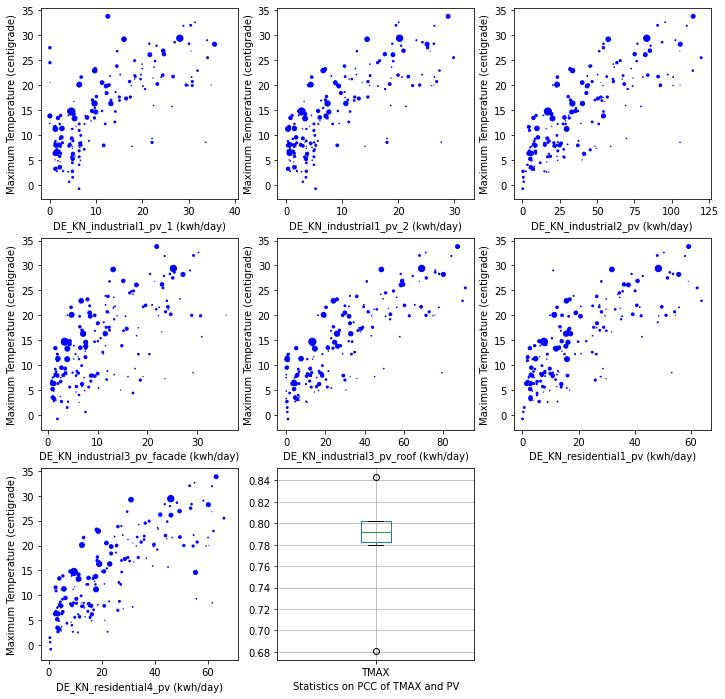

In [ ]:
# print(df['TMAX'])
df_corrM_tmax = df_merge_corrM[['TMAX']]
# df_filter_tmax = df_corrM_tmax.loc[(df_corrM_tmax['TMAX']>0.7) | (df_corrM_tmax['TMAX']<-0.7)]
df_filter_tmax = df_corrM_tmax

indexNamesArr = df_filter_tmax.index.values
lst = list(indexNamesArr)[:-2]
lst = list(filter(lambda k: 'pv' in k, lst))
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
p=0
for i, j in itertools.product(range(3), range(3)):
    if p==7:
        break
    axes[i,j].scatter(x=df_merge[lst[p]], y=df_merge['TMAX'], s=df_merge['PRCP'],color='blue')
    axes[i,j].set_xlabel(lst[p]+" (kwh/day)")
    axes[i,j].set_ylabel("Maximum Temperature (centigrade)")
    p=p+1
df_pv_tmax = df_filter_tmax.loc[lst]
df_pv_tmax.boxplot(column='TMAX', ax= axes[2,1])
axes[2,1].set_xlabel("Statistics on PCC of TMAX and PV")
axes[-1, -1].axis('off')

fig.savefig("./pics/pv_tmax_200.png", dpi=200)


In [ ]:
df_corrM_tmax.loc[lst].to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &      TMAX \\\\\n\\midrule\nDE\\_KN\\_industrial1\\_pv\\_1      &  0.779747 \\\\\nDE\\_KN\\_industrial1\\_pv\\_2      &  0.802174 \\\\\nDE\\_KN\\_industrial2\\_pv        &  0.802513 \\\\\nDE\\_KN\\_industrial3\\_pv\\_facade &  0.680595 \\\\\nDE\\_KN\\_industrial3\\_pv\\_roof   &  0.843360 \\\\\nDE\\_KN\\_residential1\\_pv       &  0.782947 \\\\\nDE\\_KN\\_residential4\\_pv       &  0.792388 \\\\\nDE\\_KN\\_residential6\\_pv       &  0.791844 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
df_filter_tmax = df_corrM_tmax.loc[(df_corrM_tmax['TMAX']>0.7) | (df_corrM_tmax['TMAX']<-0.7)]
print(df_filter_tmax.to_latex(float_format="%.2f"))

\begin{tabular}{lr}
\toprule
{} &  TMAX \\
\midrule
DE\_KN\_industrial1\_pv\_1              &  0.78 \\
DE\_KN\_industrial1\_pv\_2              &  0.80 \\
DE\_KN\_industrial2\_pv                &  0.80 \\
DE\_KN\_industrial3\_cooling\_aggregate &  0.81 \\
DE\_KN\_industrial3\_cooling\_pumps     &  0.86 \\
DE\_KN\_industrial3\_pv\_roof           &  0.84 \\
DE\_KN\_residential1\_freezer          &  0.72 \\
DE\_KN\_residential1\_heat\_pump        & -0.95 \\
DE\_KN\_residential1\_pv               &  0.78 \\
DE\_KN\_residential2\_circulation\_pump & -0.88 \\
DE\_KN\_residential3\_circulation\_pump & -0.78 \\
DE\_KN\_residential3\_freezer          &  0.75 \\
DE\_KN\_residential4\_freezer          &  0.87 \\
DE\_KN\_residential4\_grid\_export      &  0.82 \\
DE\_KN\_residential4\_grid\_import      & -0.85 \\
DE\_KN\_residential4\_heat\_pump        & -0.88 \\
DE\_KN\_residential4\_pv               &  0.79 \\
DE\_KN\_residential5\_refrigerator     &  0.71 \\
DE\_KN\_residential6\_grid\_import   

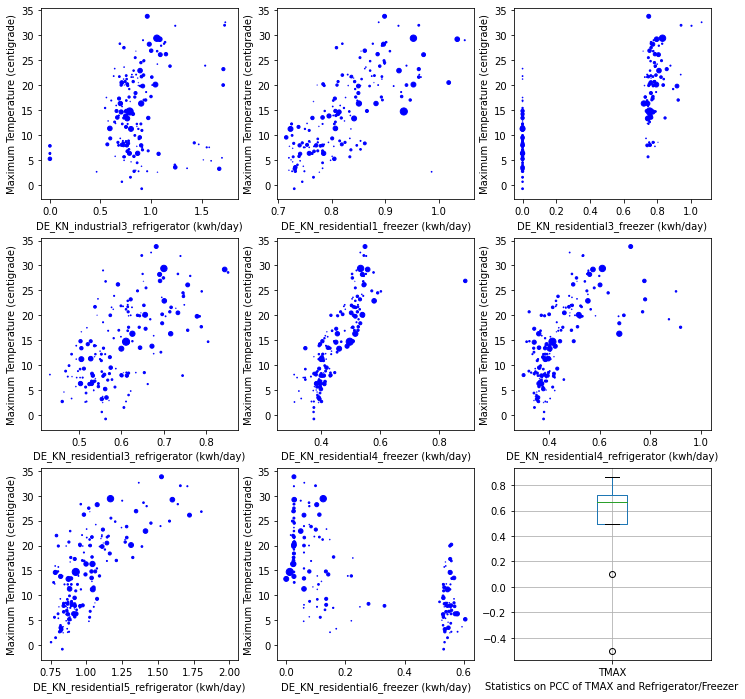

In [ ]:
# print(df['TMAX'])
df_corrM_tmax = df_merge_corrM[['TMAX']]
df_filter_tmax = df_corrM_tmax

indexNamesArr = df_filter_tmax.index.values
lst = list(indexNamesArr)[:-2]
lst = list(filter(lambda k: (('refrigerator' in k) or ('freezer' in k)), lst))
lst
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
p=0
for i, j in itertools.product(range(3), range(3)):
    if p==8:
        break
    axes[i,j].scatter(x=df_merge[lst[p]], y=df_merge['TMAX'], s=df_merge['PRCP'],color='blue')
    axes[i,j].set_xlabel(lst[p]+" (kwh/day)")
    axes[i,j].set_ylabel("Maximum Temperature (centigrade)")
    p=p+1
df_pv_tmax = df_filter_tmax.loc[lst]
df_pv_tmax.boxplot(column='TMAX', ax= axes[-1,-1])
axes[-1,-1].set_xlabel("Statistics on PCC of TMAX and Refrigerator/Freezer")

fig.savefig("./pics/freezer_tmax_200.png", dpi=200)


In [ ]:
df_corrM_tmax.loc[lst].to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &      TMAX \\\\\n\\midrule\nDE\\_KN\\_industrial3\\_refrigerator  &  0.100624 \\\\\nDE\\_KN\\_residential1\\_freezer      &  0.715874 \\\\\nDE\\_KN\\_residential3\\_freezer      &  0.753999 \\\\\nDE\\_KN\\_residential3\\_refrigerator &  0.627672 \\\\\nDE\\_KN\\_residential4\\_freezer      &  0.865966 \\\\\nDE\\_KN\\_residential4\\_refrigerator &  0.635345 \\\\\nDE\\_KN\\_residential5\\_refrigerator &  0.705125 \\\\\nDE\\_KN\\_residential6\\_freezer      & -0.506059 \\\\\n\\bottomrule\n\\end{tabular}\n'

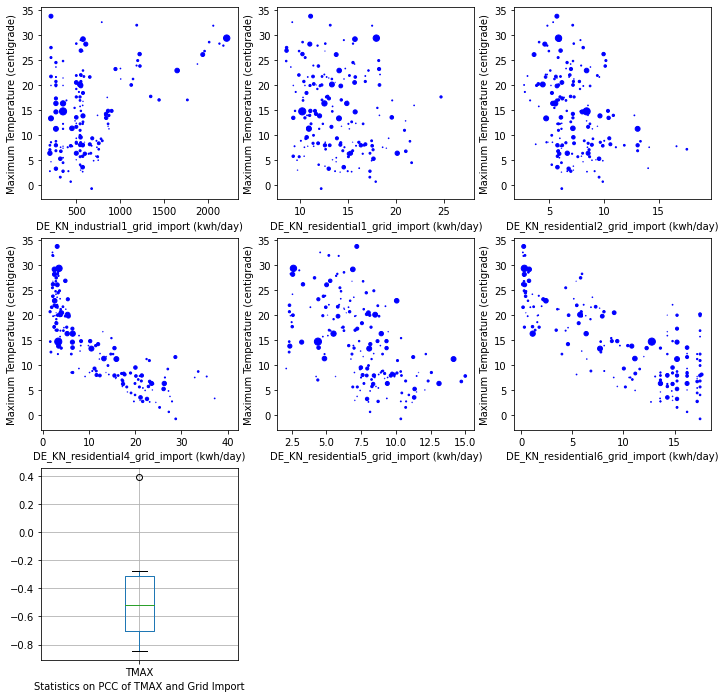

In [ ]:
# print(df['TMAX'])
df_corrM_tmax = df_merge_corrM[['TMAX']]
df_filter_tmax = df_corrM_tmax

indexNamesArr = df_filter_tmax.index.values
lst = list(indexNamesArr)[:-2]
lst = list(filter(lambda k: 'grid_import' in k, lst))
lst
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
p=0
for i, j in itertools.product(range(3), range(3)):
    if p==6:
        break
    axes[i,j].scatter(x=df_merge[lst[p]], y=df_merge['TMAX'], s=df_merge['PRCP'],color='blue')
    axes[i,j].set_xlabel(lst[p]+" (kwh/day)")
    axes[i,j].set_ylabel("Maximum Temperature (centigrade)")
    p=p+1
df_pv_tmax = df_filter_tmax.loc[lst]
df_pv_tmax.boxplot(column='TMAX', ax= axes[2,0])
axes[2,0].set_xlabel("Statistics on PCC of TMAX and Grid Import")
axes[2,1].axis('off')
axes[2,2].axis('off')

fig.savefig("./pics/grid_tmax_200.png", dpi=200)

In [ ]:
df_corrM_tmax.loc[lst].to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &      TMAX \\\\\n\\midrule\nDE\\_KN\\_industrial1\\_grid\\_import  &  0.397874 \\\\\nDE\\_KN\\_residential1\\_grid\\_import & -0.278740 \\\\\nDE\\_KN\\_residential2\\_grid\\_import & -0.418814 \\\\\nDE\\_KN\\_residential4\\_grid\\_import & -0.846956 \\\\\nDE\\_KN\\_residential5\\_grid\\_import & -0.622823 \\\\\nDE\\_KN\\_residential6\\_grid\\_import & -0.730169 \\\\\n\\bottomrule\n\\end{tabular}\n'